In [1]:
from moist_konrad import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

In [2]:
results_file = open("results_file_strong-low-atm-temp-4.txt",'w')
lambda_file = open("lambda_file_strong-low-atm-temp-4.txt",'w')
temp_file = open("temp_file_strong-low-atm-temp-4.txt",'w')
water_file = open("water_file_strong-low-atm-temp-4.txt",'w')

In [3]:
cases = [1.]
initial_temperatures = [240.,250.,260.,270.,275.,280.,285.,
                        288.,290.,292.5,295.,297.5,300.,302.5,305.,307.5,310.,315.]

initial_temperatures = [280.,285.,288.,290.,292.5,295.,297.5,300.,302.5,305.,307.5,310.]

depths = [2.5,7.5]
solar_multiplier = [1.]


land_atm_coupling = True
strong_coupling = True

albedo_sfc = 0.2

if strong_coupling == True:
    z_ref_T = 200
    z_ref_vmr = 2
else:
    z_ref_T = 2
    z_ref_vmr = 2

In [4]:
%%time

for k in range(len(solar_multiplier)):
    for de in range(len(depths)):
        for te in range(len(initial_temperatures)):
            print(depths[de],initial_temperatures[te],solar_multiplier[k])
            ###PARAMETERS OF THE TEST:

            #flux for efficiency computation:
            # 1: LH + SH
            # 2: Radiation surface
            # 3: Atmosphere radiation
            case = cases[0]
            depth_d = depths[de]


            #coupled surface-atmosphere: 
            #if true, surface fluxes and surface temperature change at each step, constant otherwise
            coupled = land_atm_coupling

            Ts_f = np.array([initial_temperatures[te]])
            print(Ts_f)

            RLS = 1/1

            #Strong coupling surface-atmosphere:
            #If true the atmosphere moist adiabat starts at surface temperature
            #If false find the atmopsheric moist adiabat that conserves energy
            strong = strong_coupling

            
            solar = 510
            angle = 47.88
            

            A = albedo_sfc

            ### INITIALIZATION
            E_imbalance = 0.

            plev, phlev = konrad.utils.get_pressure_grids(1000e2, 100, 128)
            atmosphere = konrad.atmosphere.Atmosphere(phlev)
            clearsky = konrad.cloud.ClearSky.from_atmosphere(atmosphere)
            surface = konrad.surface.SlabOcean(
                temperature=288,
                heat_sink=0,
                depth = depth_d,
                albedo = 0.5)

            radiation = konrad.radiation.RRTMG(solar_constant=solar, zenith_angle = angle)

            ndays = 10000
            timestep = 0.5 #days
            nsteps = int(ndays/timestep)

            printcounter = 0
            status = 0

            tol = 1e-5

            ### RCPE COMPUTATION

            surface['temperature'] = Ts_f
            surface.albedo = A
            atmosphere['T'][0] = moist_adiabat(surface['temperature'],atmosphere['T'][0],atmosphere)
            print(surface['temperature'],surface.albedo)

            conv_top = coldpoint(atmosphere['T'][0])
            RH = manabe_rh(0.8,atmosphere['plev'])
            atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'],conv_top)
            T_atm_low = surface['temperature']

            print(surface['temperature'],surface.albedo)

            #### RCE FOR PRESENT-DAY CO2
            atmosphere['CO2'][0] = 348/1e6
            dE = 0.

            T_sfc_1 = [1e8]
            toa_1 = [1e8]
            for i in range(nsteps):
                #surface fluxes
                z = height(atmosphere['plev'],atmosphere['T'][0],
                           atmosphere['phlev'][0],surface['temperature'])
                
                
                T_ini,vmr_ini = atmosphere['T'][0][0].copy(),atmosphere['H2O'][0,0].copy()

                #compute the fluxes or input the forcing
                LH = latent_heat(vmr_ini, T_ini,atmosphere['phlev'][0],RLS)
                SH = sensible_heat(T_ini,surface['temperature'],atmosphere['phlev'][0],RLS)



                #convective adjustment of the armosphere
                atmosphere,surface,radiation,net_rad_surface,atm_rad,\
                T_atm_low,E_imbalance,prec_mass,prec_heating,\
                RH,cold_point,prec_eff,water_content = RCPE_step_DSE(timestep,
                                                      atmosphere,surface,radiation,clearsky,
                                                      SH,LH,A,T_atm_low,dE,
                                                      strong_coupling = strong,
                                                      constrain_RH = True,
                                                    Flux_case = case)



                #update surface temperature with energetic fluxes (latent and radiative)
 
                surface['temperature'] = Ts_f


                status += 1
                if printcounter == 200:
                    print(status/2)
                printcounter += 1

                T_sfc_1.append(surface['temperature'])
                toa_1.append(radiation['toa'].copy())
                if abs(T_sfc_1[i]-T_sfc_1[i-1])<tol and abs(toa_1[i]-toa_1[i-1])<tol:
                    print(i)
                    break

            print('hehe')
            olr_rec = radiation['lw_flxu'][0,-1].copy() - radiation['lw_flxd'][0,-1].copy()
            net_sw = radiation['sw_flxd'][0,-1].copy() - radiation['sw_flxu'][0,-1].copy()
            isr_rec = radiation['sw_flxd'][0,-1].copy()
            results_file.write(str(coupled)+" "+str(depth_d)+" "+str(case)+" "+str(Ts_f)
                               +" "+str(surface['temperature'])+" "+str(T_ini)
                               +" "+str(net_rad_surface)+" "+str(atm_rad)+" "+str(radiation['toa'])
                               +" "+str(olr_rec)+" "+str(net_sw)+" "+str(isr_rec)
                               +" "+str(E_imbalance)
                               +" "+str(LH)+" "+str(SH)+" "+str(prec_eff)
                               +" "+str(prec_mass)+" "+str(LH/Lv * seconds_day)
                               +" "+str(RH[0])+" "+str(water_content)
                               +" "+str(atmosphere['CO2'][0][0])
                               +"\n")
            
            if de == 1:
                np.savetxt(temp_file,atmosphere['T'][0].reshape(1, -1).copy())
                np.savetxt(water_file,atmosphere['H2O'][0].reshape(1, -1).copy())

            P1 = prec_mass
            q1 = atmosphere['H2O'][0].copy()[0]
            RH1 = RH[0]
            
            heat_sink = radiation['toa'].copy()
            dE = E_imbalance
            print(heat_sink, dE)
            
            #### RCE FOR PRESENT-DAY CO2
            atmosphere['CO2'][0] *= 2


            T_sfc_2 = [1e8]
            toa_2 = [1e8]
            olr_2 = [1e8]
            for i in range(nsteps):
                #surface fluxes
                z = height(atmosphere['plev'],atmosphere['T'][0],
                           atmosphere['phlev'][0],surface['temperature'])
                
                T_ini,vmr_ini = atmosphere['T'][0][0].copy(),atmosphere['H2O'][0,0].copy()

                #compute the fluxes or input the forcing
                LH = latent_heat(vmr_ini, T_ini,atmosphere['phlev'][0],RLS)
                SH = sensible_heat(T_ini,surface['temperature'],atmosphere['phlev'][0],RLS)



                #convective adjustment of the armosphere
                atmosphere,surface,radiation,net_rad_surface,atm_rad,\
                T_atm_low,E_imbalance,prec_mass,prec_heating,\
                RH,cold_point,prec_eff,water_content = RCPE_step_DSE(timestep,
                                                      atmosphere,surface,radiation,clearsky,
                                                      SH,LH,A,T_atm_low,dE,
                                                      strong_coupling = strong,
                                                      constrain_RH = True,
                                                    Flux_case = case)



                #update surface temperature with energetic fluxes (latent and radiative)
                surface['temperature'] = surface['temperature'] + ((net_rad_surface - SH - LH - heat_sink - dE)
                                           * seconds_day * timestep / surface.heat_capacity)



                status += 1
                if printcounter == 200:
                    print(status/2)
                printcounter += 1

                T_sfc_2.append(surface['temperature'])
                toa_2.append(radiation['toa'].copy())
                olr_2.append(radiation['lw_flxu'][0,-1].copy() - radiation['lw_flxd'][0,-1].copy())

                if abs(T_sfc_2[i]-T_sfc_2[i-1])<tol and abs(toa_2[i]-toa_2[i-1])<tol:
                    print(i)
                    break

            print('hehe2')
            olr_rec = radiation['lw_flxu'][0,-1].copy() - radiation['lw_flxd'][0,-1].copy()
            net_sw = radiation['sw_flxd'][0,-1].copy() - radiation['sw_flxu'][0,-1].copy()
            isr_rec = radiation['sw_flxd'][0,-1].copy()
            results_file.write(str(coupled)+" "+str(depth_d)+" "+str(case)+" "+str(Ts_f)
                               +" "+str(surface['temperature'])+" "+str(T_ini)
                               +" "+str(net_rad_surface)+" "+str(atm_rad)+" "+str(radiation['toa'])
                               +" "+str(olr_rec)+" "+str(net_sw)+" "+str(isr_rec)
                               +" "+str(E_imbalance)
                               +" "+str(LH)+" "+str(SH)+" "+str(prec_eff)
                               +" "+str(prec_mass)+" "+str(LH/Lv * seconds_day)
                               +" "+str(RH[0])+" "+str(water_content)
                               +" "+str(atmosphere['CO2'][0][0])
                               +"\n")
            
            if de == 1:
                np.savetxt(temp_file,atmosphere['T'][0].reshape(1, -1).copy())
                np.savetxt(water_file,atmosphere['H2O'][0].reshape(1, -1).copy())

            P2 = prec_mass
            q2 = atmosphere['H2O'][0].copy()[0]
            RH2 = RH[0]

            T1 = T_sfc_1[-1]
            T2 = np.array(T_sfc_2[1:])
            toa2 = np.array(toa_2[1:])
            olr2 = np.array(olr_2[1:])


            T_anom = T2 - T1

            lambda_1 = linregress( T_anom[200:,0], toa2[200:,0]).slope
            lambda_2 = linregress( T_anom[200:,0], olr2[200:]).slope


            lambda_file.write(str(coupled)+" "+str(depth_d)+" "+str(case)+" "+str(Ts_f)
                             +" "+str(olr_rec)+" "+str(net_sw)+" "+str(isr_rec)
                             +" "+str(T_anom[-1])+" "+str(lambda_1)+" "+str(lambda_2)
                             +" "+str((P2-P1)/P1*100/T_anom[-1])
                             +" "+str((q2-q1)/q1*100/T_anom[-1])
                             +" "+str(np.max(toa2))+" "+str(np.min(olr2))
                             +"\n")
    


2.5 280.0 1.0
[280.]
[280.] 0.2
[280.] 0.2
100.5
413
hehe
[26.20405792]
1169
hehe2
2.5 285.0 1.0
[285.]
[285.] 0.2
[285.] 0.2
100.5
374
hehe
[15.71898269]
1285
hehe2
2.5 288.0 1.0
[288.]
[288.] 0.2
[288.] 0.2
195
hehe
[9.26302648]
100.5
1342
hehe2
2.5 290.0 1.0
[290.]
[290.] 0.2
[290.] 0.2
175
hehe
[4.92528338]
100.5
1398
hehe2
2.5 292.5 1.0
[292.5]
[292.5] 0.2
[292.5] 0.2
114
hehe
[-0.55521983]
100.5
1528
hehe2
2.5 295.0 1.0
[295.]
[295.] 0.2
[295.] 0.2
100.5
353
hehe
[-6.12288468]
1551
hehe2
2.5 297.5 1.0
[297.5]
[297.5] 0.2
[297.5] 0.2
100.5
350
hehe
[-11.77444672]
1794
hehe2
2.5 300.0 1.0
[300.]
[300.] 0.2
[300.] 0.2
100.5
272
hehe
[-17.60247093]
1669
hehe2
2.5 302.5 1.0
[302.5]
[302.5] 0.2
[302.5] 0.2
100.5
282
hehe
[-23.64045813]
1934
hehe2
2.5 305.0 1.0
[305.]
[305.] 0.2
[305.] 0.2
189
hehe
[-29.50216395]
100.5
2141
hehe2
2.5 307.5 1.0
[307.5]
[307.5] 0.2
[307.5] 0.2
176
hehe
[-35.30625203]
100.5
2217
hehe2
2.5 310.0 1.0
[310.]
[310.] 0.2
[310.] 0.2
152
hehe
[-41.3332532]
100.5


In [5]:
temp_file.close()
water_file.close()
results_file.close()
lambda_file.close()

In [6]:
print(T_anom[200:,0])

[0.64825447 0.65103156 0.65380074 ... 2.1514743  2.15148419 2.15149408]


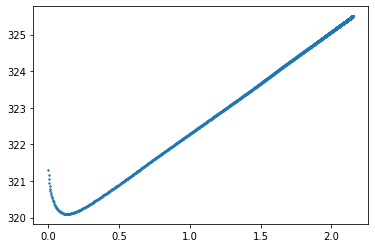

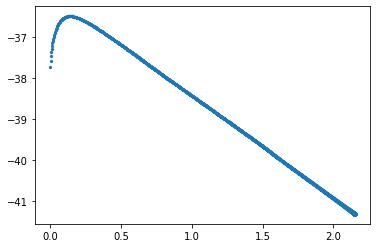

In [7]:
plt.scatter(T_anom[:,0], olr2[:], s = 2)
plt.show()
plt.scatter(T_anom[:,0], toa2[:,0], s = 5)
plt.show()

In [8]:
lambda_1 = linregress( T_anom[500:,0], toa2[500:,0]).slope
lambda_2 = linregress( T_anom[500:,0], olr2[500:]).slope
print(lambda_1,lambda_2)

-2.5186446775443136 2.812698815893832


In [9]:
print(radiation['sw_flxd'][0,-1])

342.04899860782075


In [10]:
print(plev)
print(phlev)
print(z)

[98649.49096825 95982.70677655 93348.64798487 90748.60669154
 88183.79685561 85655.35445494 83164.33780182 80711.72801105
 78298.42961472 75925.27131802 73593.00689003 71302.31618318
 69053.80627507 66848.01272581 64685.40094449 62566.3676576
 60491.24247274 58460.28953049 56473.7092376  54531.6400743
 52634.1604689  50781.29073271 48972.99504834 47209.18350463
 45489.71417153 43814.39520823 42182.98699838 40595.20430578
 39050.71844465 37549.15945857 36090.11830215 34673.14902021
 33297.77091887 31963.47072369 30669.70471994 29415.90087041
 28201.46090639 27025.7623878  25888.16072851 24787.99118341
 23724.57079381 22697.20028815 21705.16593514 20747.74134695
 19824.18923    18933.7630813  18075.70882874 17249.26641353
 16453.6713136  15688.15600694 14951.95137381 14244.28803738
 13564.39764219 12911.51407038 12284.87459539 11683.7209735
 11107.30047334 10554.86684393 10025.68122188  9519.01297839
  9034.14050716  8570.35195402  8126.94588956  7703.23192601
  7298.53127956  6912.17727